In [0]:
import matplotlib.pyplot as plt

In [0]:
import pandas as pd
import numpy as np

In [0]:
daily = pd.read_csv('productDailyActions.csv')
attributes = pd.read_csv('productAttributes.csv')

In [45]:
daily.head()

,productid,date,soldquantity,stock,clickcount,favoredcount
0,1,2018-11-23,0,140,82.0,NaN
1,21,2018-11-30,0,3,11.0,NaN
2,21,2018-12-27,0,2,2.0,NaN
3,21,2019-01-09,0,2,2.0,1.0
4,21,2018-12-18,0,2,5.0,NaN


In [46]:
daily.drop(['productid','stock', 'clickcount','favoredcount'], axis=1)

,date,soldquantity
0,2018-11-23,0
1,2018-11-30,0
2,2018-12-27,0
3,2019-01-09,0
4,2018-12-18,0
...,...,...
858930,2018-12-12,0
858931,2018-12-26,0
858932,2019-01-01,0
858933,2019-01-03,0


In [0]:
daily.drop(daily[(daily.date == '2018-11-09')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-11-10')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-11-11')].index, axis=0, inplace=True)

daily.drop(daily[(daily.date == '2018-11-20')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-11-21')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-11-22')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-11-23')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-11-24')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-11-25')].index, axis=0, inplace=True)

daily.drop(daily[(daily.date == '2018-12-20')].index, axis=0, inplace=True)
daily.drop(daily[(daily.date == '2018-12-21')].index, axis=0, inplace=True)

In [0]:
daily_new = daily.groupby('date')['soldquantity'].sum().reset_index()

In [49]:
daily_new

,date,soldquantity
0,2018-11-01,3640
1,2018-11-02,3424
2,2018-11-03,3060
3,2018-11-04,3274
4,2018-11-05,3445
...,...,...
56,2019-01-07,2954
57,2019-01-08,3828
58,2019-01-09,3778
59,2019-01-10,3584


In [0]:
daily_new['date'] = pd.to_datetime(daily_new['date'], errors='coerce')

In [0]:
daily_new['date'] = daily_new['date'].dt.strftime('%d%m%Y')

In [52]:
daily_new.head()

,date,soldquantity
0,01112018,3640
1,02112018,3424
2,03112018,3060
3,04112018,3274
4,05112018,3445


In [53]:
daily_new.shape

(61, 2)

In [0]:
train, test = daily_new[:-12], daily_new[-12:]

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

In [0]:
n_input = 12
n_features = 2
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=32)

In [0]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='mse')

In [71]:
model.fit_generator(generator,epochs=90)

Epoch 1/90
2/2 [==============================] - 0s 186ms/step - loss: 0.1069
Epoch 2/90
2/2 [==============================] - 0s 27ms/step - loss: 0.0997
Epoch 3/90
2/2 [==============================] - 0s 26ms/step - loss: 0.0872
Epoch 4/90
2/2 [==============================] - 0s 28ms/step - loss: 0.0785
Epoch 5/90
2/2 [==============================] - 0s 26ms/step - loss: 0.0715
Epoch 6/90
2/2 [==============================] - 0s 27ms/step - loss: 0.0693
Epoch 7/90
2/2 [==============================] - 0s 27ms/step - loss: 0.0742
Epoch 8/90
2/2 [==============================] - 0s 26ms/step - loss: 0.0717
Epoch 9/90
2/2 [==============================] - 0s 27ms/step - loss: 0.0720
Epoch 10/90
2/2 [==============================] - 0s 27ms/step - loss: 0.0697
Epoch 11/90
2/2 [==============================] - 0s 27ms/step - loss: 0.0678
Epoch 12/90
2/2 [==============================] - 0s 27ms/step - loss: 0.0672
Epoch 13/90
2/2 [==============================] - 0s 26ms/s

In [0]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [0]:
daily_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=daily_new[-n_input:].index, columns=['Prediction1','Prediction'])

daily_test = pd.concat([daily_new,daily_predict], axis=1)


No handles with labels found to put in legend.


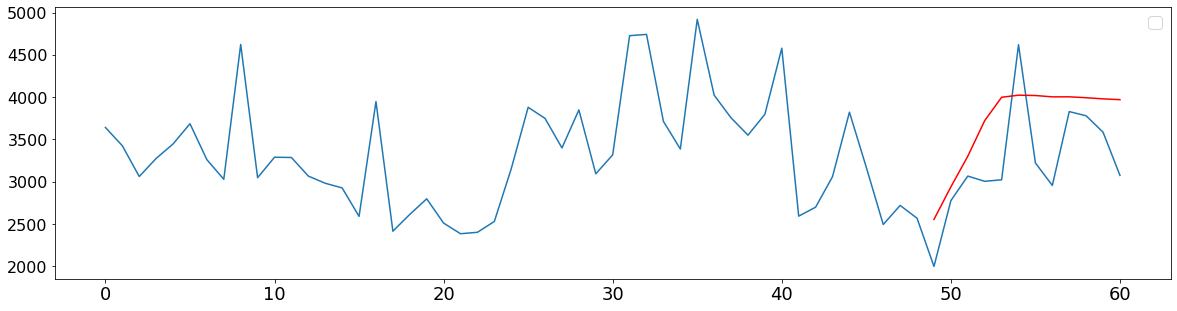

In [74]:
plt.figure(figsize=(20, 5))
plt.plot(daily_test.index, daily_test['soldquantity'])
plt.plot(daily_test.index, daily_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [107]:
a = daily_test.iloc[-n_input:, [0]]

print(a)

        date
49  31122018
50  01012019
51  02012019
52  03012019
53  04012019
54  05012019
55  06012019
56  07012019
57  08012019
58  09012019
59  10012019
60  11012019


In [0]:
b = daily_test.iloc[-n_input:, [1]]

In [91]:
daily_test.fillna(0)

,date,soldquantity,Prediction1,Prediction
0,01112018,3640,0.000000e+00,0.000000
1,02112018,3424,0.000000e+00,0.000000
2,03112018,3060,0.000000e+00,0.000000
3,04112018,3274,0.000000e+00,0.000000
4,05112018,3445,0.000000e+00,0.000000
...,...,...,...,...
56,07012019,2954,1.159971e+07,4002.185904
57,08012019,3828,1.159411e+07,4002.674596
58,09012019,3778,1.171708e+07,3991.925341
59,10012019,3584,1.186949e+07,3978.601725


In [108]:
pred_actual_rmse = rmse(a, b)
print("rmse: ", pred_actual_rmse)

TypeError: ignored